## Labwork 6 | Distance

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

def to_cartesian(p):
    return p[:2] / p[2]
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

def plot(*shapes,
         size=6,
         lim=15,
         major=5,
         with_points=True,
         point_size=5,
         close=True,
         from_origin=False,
         show_legend=False,
         **common_plot_kw):
    fig, ax = plt.subplots(figsize=(size, size))

    for item in shapes:
        if isinstance(item, tuple):
            shape, plot_kw = item
        else:
            shape, plot_kw = item, {}

        shape = np.asarray(shape)
        x = shape[:, 0] / shape[:, 2]
        y = shape[:, 1] / shape[:, 2]

        if close:
            xx = np.append(x, x[0])
            yy = np.append(y, y[0])
        else:
            xx, yy = x, y

        if "facecolor" in plot_kw:
            ax.fill(xx, yy, **plot_kw)
        else:
            ax.plot(xx, yy, **({"linewidth": 1.6} | common_plot_kw | plot_kw))

        if with_points:
            ax.scatter(x, y, s=point_size, zorder=3)

    ax.set_aspect("equal")

    if from_origin:
        ax.set_xlim(0, lim)
        ax.set_ylim(0, lim)
        major_ticks = np.arange(0, lim + 1, major)
        minor_ticks = np.arange(0, lim + 1, 1)
    else:
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        major_ticks = np.arange(-lim, lim + 1, major)
        minor_ticks = np.arange(-lim, lim + 1, 1)

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which="major", linestyle="-", linewidth=0.8)
    ax.grid(which="minor", linestyle=":", linewidth=0.5)

    if show_legend:
        ax.legend()

    plt.show()



### Task 1

Задайте множество $E$ точек $P_1, P_2, \ldots, P_{10}$.

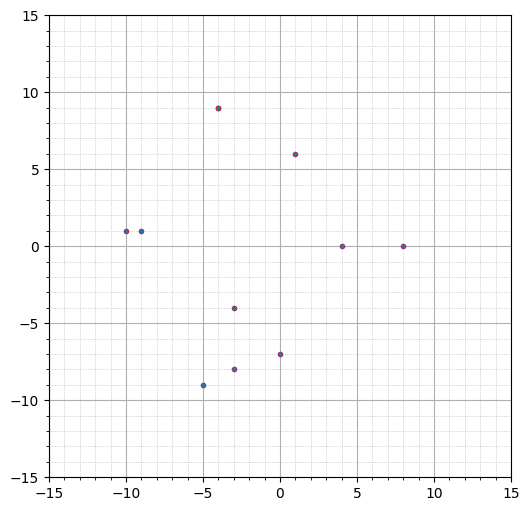

In [12]:
np.random.seed(42)
points_2d = np.random.randint(-10, 10, size=(10, 2))
points = np.hstack([points_2d, np.ones((points_2d.shape[0], 1))])

plot((points, {"color": "red", "label": "intersections", "marker": ".", "linestyle": "None"}))

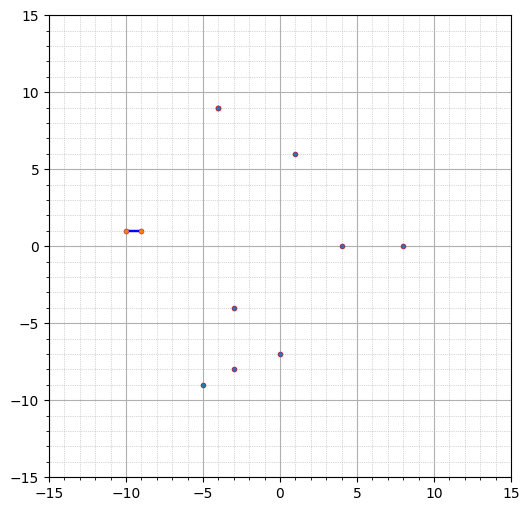

In [13]:
min_dist = float("inf")
closest_pair = None
for i, j in combinations(range(len(points)), 2):
    d = np.linalg.norm(points[i][:2] - points[j][:2])
    if d < min_dist:
        min_dist = d
        closest_pair = (i, j)

# Extract the pair
p1, p2 = points[closest_pair[0]], points[closest_pair[1]]
segment = np.vstack([p1, p2])

plot((points, {"color": "red", "label": "intersections", "marker": ".", "linestyle": "None"}),
     (segment, {"color": "blue", "label": "closest pair", "linestyle": "-"}))

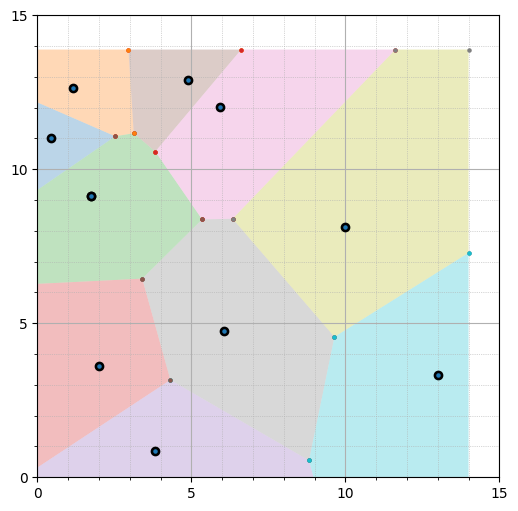

In [25]:
def bisector(p1, p2):
    mid = (p1 + p2) / 2
    dx, dy = p2 - p1
    A = dx
    B = dy
    C = A * mid[0] + B * mid[1]
    return A, B, C

def clip_polygon(polygon, A, B, C):
    new_poly = []
    n = len(polygon)
    for i in range(n):
        cur = polygon[i]
        nxt = polygon[(i + 1) % n]
        cur_inside = (A * cur[0] + B * cur[1]) <= C
        nxt_inside = (A * nxt[0] + B * nxt[1]) <= C
        if cur_inside:
            new_poly.append(cur)
        if cur_inside != nxt_inside:
            denom = A * (nxt[0] - cur[0]) + B * (nxt[1] - cur[1])
            if abs(denom) < 1e-10:
                continue
            t = (C - (A * cur[0] + B * cur[1])) / denom
            intersect_point = cur + t * (nxt - cur)
            new_poly.append(intersect_point)
    return np.array(new_poly)

class VoronoiCell:
    def __init__(self, site, polygon):
        self.site = site
        self.polygon = polygon

class VoronoiDiagram:
    def __init__(self, cells):
        self.cells = cells

def voronoi_divide_and_conquer(points, bbox):
    n = len(points)
    if n == 1:
        return VoronoiDiagram([VoronoiCell(points[0], bbox.copy())])
    if n == 2:
        A, B, C = bisector(points[0], points[1])
        cell0 = clip_polygon(bbox.copy(),  A,  B,  C)
        cell1 = clip_polygon(bbox.copy(), -A, -B, -C)
        return VoronoiDiagram([
            VoronoiCell(points[0], cell0),
            VoronoiCell(points[1], cell1)
        ])

    idx = np.argsort(points[:,0])
    points = points[idx]
    mid = n // 2
    left = voronoi_divide_and_conquer(points[:mid], bbox)
    right = voronoi_divide_and_conquer(points[mid:], bbox)

    return merge_voronoi(left, right, bbox)

def merge_voronoi(left, right, bbox):
    all_cells = []

    left_sites = [cell.site for cell in left.cells]
    right_sites = [cell.site for cell in right.cells]

    for cell in left.cells:
        poly = cell.polygon.copy()
        for r in right_sites:
            A, B, C = bisector(cell.site, r)
            if (A * r[0] + B * r[1]) < (A * cell.site[0] + B * cell.site[1]):
                A, B, C = -A, -B, -C
            poly = clip_polygon(poly, A, B, C)
            if len(poly) == 0:
                break
        all_cells.append(VoronoiCell(cell.site, poly))

    for cell in right.cells:
        poly = cell.polygon.copy()
        for l in left_sites:
            A, B, C = bisector(cell.site, l)
            if (A * l[0] + B * l[1]) < (A * cell.site[0] + B * cell.site[1]):
                A, B, C = -A, -B, -C
            poly = clip_polygon(poly, A, B, C)
            if len(poly) == 0:
                break
        all_cells.append(VoronoiCell(cell.site, poly))

    return VoronoiDiagram(all_cells)

np.random.seed(43)
points = np.random.rand(10, 2) * 15
min_x, min_y = np.min(points, axis=0) - 1
max_x, max_y = np.max(points, axis=0) + 1
bbox = np.array([
    [min_x, min_y],
    [min_x, max_y],
    [max_x, max_y],
    [max_x, min_y]
])

# Compute diagram
diagram = voronoi_divide_and_conquer(points, bbox)

shapes = [
    (np.hstack([np.array(cell.polygon), np.ones((len(cell.polygon), 1))]), {
        "facecolor": f"C{i % 10}", "alpha": 0.3, "label": f"cell {i}"
    })
    for i, cell in enumerate(diagram.cells) if len(cell.polygon) > 0
]

points_hom = np.hstack([points, np.ones((len(points), 1))])
shapes.append((points_hom, {"color": "black", "marker": "o", "linestyle": "None", "label": "Sites"}))

# Plot using user's plot function
plot(*shapes, from_origin=True, show_legend=False, close=True)